## Sentiment Analysis 

### Given a csv file of reviews, Create a module to predict a binary sentiment (positive 1, negative 0)

#### This task will we executed using OOP with Keras (TensorFlow), Sklearn, Pandas and Numpy



In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 

import nltk
stopwords = nltk.corpus.stopwords.words('english')

#Initialize Stemm cleaner and Lemmatizer for future text analysis and processing for RNN model
from nltk.stem import PorterStemmer, WordNetLemmatizer
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

from textblob import TextBlob, Word, Blobber

import tensorflow as tf 
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
tf.random.set_seed(42)

from random import choice


%matplotlib inline 

In [3]:
df_reviews = pd.read_csv('reviews.csv', )

with pd.option_context('display.max_colwidth', None):
    display(df_reviews.head(4))

,review,sentiment
0,"Love the staff, love the meat, love the place. Prepare for a long line around lunch or dinner hours. \n\nThey ask you how you want you meat, lean or something maybe, I can't remember. Just say you don't want it too fatty. \n\nGet a half sour pickle and a hot pepper. Hand cut french fries too.",1
1,Super simple place but amazing nonetheless. It's been around since the 30's and they still serve the same thing they started with: a bologna and salami sandwich with mustard. \n\nStaff was very helpful and friendly.,1
2,Small unassuming place that changes their menu every so often. Cool decor and vibe inside their 30 seat restaurant. Call for a reservation. \n\nWe had their beef tartar and pork belly to start and a salmon dish and lamb meal for mains. Everything was incredible! I could go on at length about how all the listed ingredients really make their dishes amazing but honestly you just need to go. \n\nA bit outside of downtown montreal but take the metro out and it's less than a 10 minute walk from the station.,1
3,Lester's is located in a beautiful neighborhood and has been there since 1951. They are known for smoked meat which most deli's have but their brisket sandwich is what I come to montreal for. They've got about 12 seats outside to go along with the inside. \n\nThe smoked meat is up there in quality and taste with Schwartz's and you'll find less tourists at Lester's as well.,1


This are Resturant recommendations (ans some noise - not relevant reviews, comments, as well German ahd Chinese reviews (who should be translated or removed in the future analysis and preperations)

## OOP Classes for future code and Train/val/Test split function

### 1) Preprocessing
This class input is pandas DataFram with reviews (text) to preprocess:
a) lower all capitalized words and remove punctuation, new line marks and numbers

b) convert test strings to a list of words 

c) remove stop swords and lammatize the words (keep the meaning and find the root of the different words in text) 

     * Different approach will be stemming the words (with the risk of loosing meaning and by that important data) 


In [4]:
class Preprocessor():
    
    def __init__(self, X, y):
        self.x = X
        self.y = y.to_numpy()
        
    def Process(self):    
        self.x = self.x.apply(lambda x: x.lower())                                             # lowering strings
        self.x = self.x.str.replace('[^\w\s]', "", regex = True)                               # removing punctuation 
        self.x = self.x.str.replace(r'\\n',' ', regex=True)                                    # removing newline 
        self.x = self.x.str.replace(r'\\t',' ', regex=True)                                    
        self.x = self.x.apply(lambda x: ''.join([i for i in x if not i.isdigit()]))            # removing numbers 
        self.x = self.x.apply(lambda x: x.split())                                             # text to list 
        self.x = self.x.apply(lambda x: [item for item in x if item not in stopwords])         # removing stopwords
        self.x = self.x.apply(lambda x: [lemmatizer.lemmatize(word) for word in x])            # Lemmatizing
        
        return self.x, self.y
    
    def to_list(self):
        return self.x.tolist(), self.y.tolist()

### 2) Vectorization
Using tensorflow Tokenizer, the vector presentation of our comments will be unique numbers, even though this method creates
a problem regardig the similarities and 'distasnces' between the words, the sequential network will include an embadding layet
to overcome this gap

In [5]:
def vectorization_pad(data, max_len=500):
    data = data
    tokenizer = Tokenizer(num_words=5000)
    tokenizer.fit_on_texts(data.tolist())
    vocab_size = len(tokenizer.word_index) + 1

    encoded_txt = tokenizer.texts_to_sequences(data.tolist())

    padded_sequence = pad_sequences(encoded_txt, maxlen = max_len)
    
    return vocab_size, padded_sequence

### 3) TrainValidTestSplit

In [6]:
from sklearn.model_selection import train_test_split

def trainValidTestSplit(X, y):
    '''
    X, y inputs in a list/array type
    print function is to make sure the labels are balanced through train, validation and test, to avoid underfitting.
    '''
    
    X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.2, random_state=1)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)
    
    print("Train set shape is: {}, with {} obsv labeld 0, {} obsv labeld 1".format(X_train.shape, 
                                                                             np.unique(y_train, return_counts= True)[1][0],
                                                                            np.unique(y_train, return_counts= True)[1][1]))
    
    print("Validation set shape is: {}, with {} obsv labeld 0, {} obsv labeld 1".format(X_val.shape, 
                                                                             np.unique(y_val, return_counts= True)[1][0],
                                                                            np.unique(y_val, return_counts= True)[1][1]))
    
    print("Test set shape is: {}, with {} obsv labeld 0, {} obsv labeld 1".format(X_test.shape, 
                                                                             np.unique(y_test, return_counts= True)[1][0],
                                                                            np.unique(y_test, return_counts= True)[1][1]))

    return X_train, X_val, X_test, y_train, y_val, y_test

### 4) RNN Model 

In [7]:
class MySequential(tf.keras.Model):
    '''
        Embedding Layer inputs
    vocab size (int): size of the input layer, determined by the vectorization step.
    embed_vector (int): output layer size, the dimension of embedded information (Hyperparameter)
    '''
    
    def __init__(self, vocab_size, embed_vector = 32, dropout1D = 0.25, dropout2 = 0.2):
        super(MySequential, self).__init__()
        
        self.embadding = tf.keras.layers.Embedding(input_dim = vocab_size, output_dim = embed_vector, input_length=200)
        self.spatialdrop = tf.keras.layers.SpatialDropout1D(dropout1D)
        self.lstm1 =  tf.keras.layers.LSTM(50, dropout=0.5, recurrent_dropout=0.5)
        self.dropout = tf.keras.layers.Dropout(dropout2)
        self.dense1 = tf.keras.layers.Dense(units = 1, activation='sigmoid')

        
    def __call__(self, inputs, training=False):
        x = self.embadding(inputs)
        x = self.spatialdrop(x)
        x = self.lstm1(x)
        x = self.dropout(x)
        
        return self.dense1(x)

### 5) Hyperparameter tuning

In [8]:
'''
        Hyperparametrs to tune are:
- embed_vector: this parameter determines the vector length for the first layer and describes similarity scores between
                all words in the Tokenized dictionary, increasing and decreasing this value can change the model accuracy. 
- epochs: number of times the whole training set is beeing fed to the RNN 
- batch_size
- dropout parameter 1D: precentage of neurons to shut-down on first  1D dropout layer
- dropout2: precentage of neurons to shut-down on 2nd neurons layer
- loss: addionalty to creating a customized with regullization over weights and combining different types of weighted - losses,
    compiling the model over different loss function to analyse model preformences over them.
    
    
        Additional Hyperparameters: 
- #layers
- Weight initalizer  (embeddings_initializer)
- Learning rate
'''

class HyperparameterTuner_Randomized():
    
    '''
        Input Param_grid (dictionary) parameters:
    - embed_vector
    - dropout_param1D
    - dropout_param
    - epochs
    - batch_sizewe
    - optimizer
    
    -n_iter - number of samples to search in RandomSearch
    
        Class Atributes:
    - parameters - Best parameters in random search from a given grid
    - loss - Best loss values
    - accuracy, val_accuracy - Accuracy and validation acc achieved from best loss 

    '''
    
    def __init__(self, param_grid, vocab_size, X_train, Y_train, X_valid, Y_valid, n_iter=10):
        
        self.voc_size = vocab_size
        self.grid = param_grid
        
        self.parameters = {}
        self.accuracy = 0
        self.loss = 1e3
        self.loss_prev = 1e3

        for i in range(n_iter):
            
            embed_vec = choice(list(self.grid.get('embed_vector')))
            dropout1D_param = choice(list(self.grid.get('dropout_param1D')))
            dropout_p2 = choice(list(self.grid.get('dropout_param')))
            opt = choice(list(self.grid.get('optimizer')))
            batch = choice(list(self.grid.get('batch_size')))
            epochs = choice(list(self.grid.get('epochs')))
            
            print(""" Iteration #{},
            The chosen parameters are:
            Embed_vector:                    {},
            Dropout:                    {}, {},
            Optimizer:                       {},
            Batch & Epoch:              {}, {}
            """.format(i+1,
            embed_vec, dropout1D_param, dropout_p2, opt, batch, epochs))
            
            model = MySequential(self.voc_size, embed_vector = embed_vec, dropout1D=dropout1D_param, dropout2=dropout_p2)
            model.compile(loss='binary_crossentropy', optimizer= opt, metrics=['accuracy'])
            history = model.fit(X_train, Y_train, validation_data = (X_valid, Y_valid), batch_size=batch, epochs =epochs,
                                verbose = 0) 
            
            loss = history.history['loss'][-1]
            
            if loss < self.loss_prev:
                self.loss = loss
                self.loss_prev = loss
                
                self.parameters = {
                    'embed_vector':embed_vec,
                    'dropout_param1D':dropout1D_param,
                    'dropout_1param':dropout_p2,
                    'optimizer': opt,
                    'batch_size': batch,
                    'epochs': epochs
                }
                
                self.accuracy =  history.history['accuracy'][-1]
                self.val_accuracy = history.history['val_accuracy'][-1]
                
            print('sample #{} is done, {} samples left'.format(i+1, n_iter-(i+1)))
            print('current accuracy is {}'.format(self.accuracy))
            print('- - - - - - - - - - - - - - - - - - - - - -')
                        

        print('Tuner is done')


## EDA - Exploratery Data Analysis 

Unerstand the data

In [9]:
pro = Preprocessor(df_reviews['review'], df_reviews['sentiment'])
data, target = pro.Process()

In [10]:
df_reviews.shape

(60000, 2)

Number of observations is 60,000

In [11]:
df_reviews['sentiment'].value_counts()

1    30000
0    30000
Name: sentiment, dtype: int64

Balanced Data set with 30,000 positive (1) reviews and 30,000 (0) negative reviews 

In [12]:
df_reviews['review_len'] = df_reviews['review'].astype(str).apply(len)
df_reviews['word_count'] = df_reviews['review'].apply(lambda x: len(str(x).split()))
df_reviews['procc_review'] = data 
df_reviews['procc_len'] = df_reviews['procc_review'].apply(lambda x: len(x))
df_reviews.head(4)

,review,sentiment,review_len,word_count,procc_review,procc_len
0,"Love the staff, love the meat, love the place....",1,293,56,"[love, staff, love, meat, love, place, prepare...",36
1,Super simple place but amazing nonetheless. It...,1,215,35,"[super, simple, place, amazing, nonetheless, a...",18
2,Small unassuming place that changes their menu...,1,506,91,"[small, unassuming, place, change, menu, every...",51
3,Lester's is located in a beautiful neighborhoo...,1,375,67,"[lesters, located, beautiful, neighborhood, si...",32


In [13]:
df_reviews['polarity'] = df_reviews['review'].map(lambda text: TextBlob(text).sentiment.polarity)
df_reviews.head()

,review,sentiment,review_len,word_count,procc_review,procc_len,polarity
0,"Love the staff, love the meat, love the place....",1,293,56,"[love, staff, love, meat, love, place, prepare...",36,0.131481
1,Super simple place but amazing nonetheless. It...,1,215,35,"[super, simple, place, amazing, nonetheless, a...",18,0.251389
2,Small unassuming place that changes their menu...,1,506,91,"[small, unassuming, place, change, menu, every...",51,0.291667
3,Lester's is located in a beautiful neighborhoo...,1,375,67,"[lesters, located, beautiful, neighborhood, si...",32,0.295833
4,Love coming here. Yes the place always needs t...,1,527,101,"[love, coming, yes, place, always, need, floor...",52,0.192857


<AxesSubplot:xlabel='polarity', ylabel='Count'>

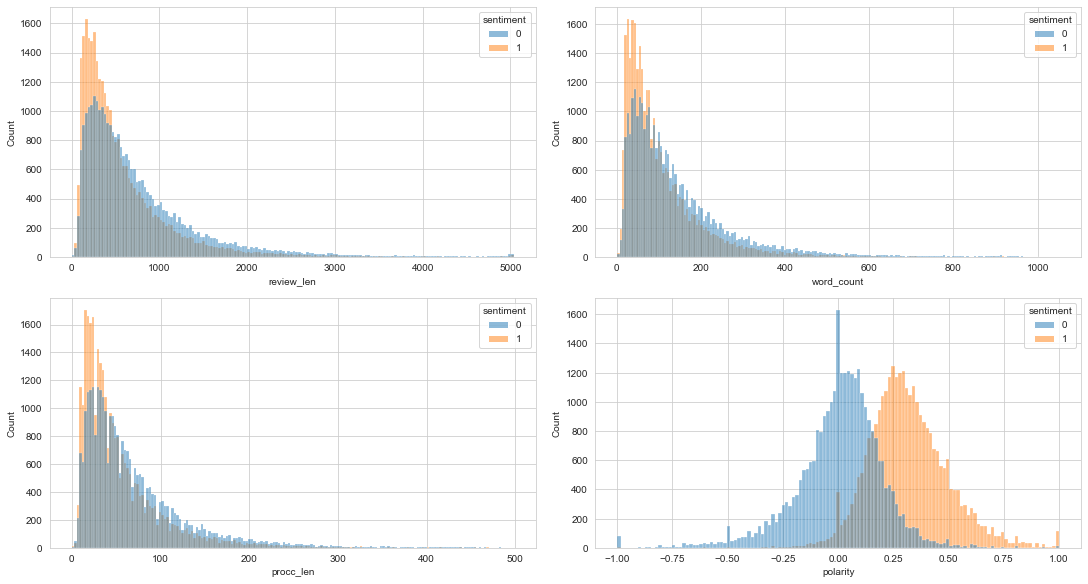

In [19]:
fig1, axes1 = plt.subplots(2,2, constrained_layout=True, figsize=(15,8))
sns.set_style('whitegrid')

sns.histplot(data = df_reviews, x= 'review_len', hue ='sentiment', ax=axes1[0,0])
sns.histplot(data = df_reviews, x= 'word_count', hue ='sentiment', ax=axes1[0,1])
sns.histplot(data = df_reviews, x= 'procc_len', hue ='sentiment', ax=axes1[1,0])
sns.histplot(data = df_reviews, x= 'polarity', hue ='sentiment', ax=axes1[1,1])

In [15]:
print(df_reviews['procc_len'].max())
list1 = df_reviews[df_reviews['procc_len'] >=500]
list1

779


,review,sentiment,review_len,word_count,procc_review,procc_len,polarity
436,Does anyone remember when Mill Avenue used to ...,1,4979,872,"[anyone, remember, mill, avenue, used, fun, pl...",504,0.153372
15661,Ein Familientreffen führte uns (acht Personen)...,1,4197,564,"[ein, familientreffen, führte, un, acht, perso...",544,0.000000
18965,Allgemein\n\n\nAm 04.12.2013 wurde ich zu eine...,0,5000,832,"[allgemeinnnnam, wurde, ich, zu, einen, essen,...",779,0.000000
18990,Kürzlich habe ich aus Termin-Gründen gleich zw...,1,4352,623,"[kürzlich, habe, ich, au, termingründen, gleic...",600,0.140000
20946,"Ikea.\nVier Buchstaben, die für den einen das ...",1,4008,572,"[ikeanvier, buchstaben, die, für, den, einen, ...",546,0.367188
32671,"Zu Anfang wenn man an kommt, wird man von eine...",1,4630,713,"[zu, anfang, wenn, man, kommt, wird, man, von,...",684,0.312500
48511,Wir waren zum zweiten Mal am Wochenende in der...,0,4203,680,"[wir, waren, zum, zweiten, mal, wochenende, de...",652,0.000000
48513,Zwar ist Leonberg nicht die Hochburg feiner Re...,0,3872,597,"[zwar, ist, leonberg, nicht, die, hochburg, fe...",576,0.750000
57845,J'ai pris rendez-vous avec l'académie pour une...,0,3161,564,"[jai, pris, rendezvous, avec, lacadémie, pour,...",528,0.225000


In [16]:
''' Using describe(), 75% of  length of procc_review is around 80 strings in it, Yet - the max len of characters 
is over 700. As we can see from the following block of code,8 out of 9 with more then 500 chars is in German,
and therfore will be dropped from the observations, regarding the additional observation in English - from quick reading this
is more of a story then a  review and therfore more noise then helpful for our model. (*also the dropped set is balanced so
the new dataset will be close to balanced still) 
all will be dropped
(the additional 1 observation with over 500 is anot )
'''

drop_idx = df_reviews[df_reviews['procc_len'] >=500].index.tolist()
df_reviews.drop(drop_idx, axis = 0, inplace = True)

print(df_reviews['sentiment'].value_counts())

0    29996
1    29995
Name: sentiment, dtype: int64


<AxesSubplot:xlabel='polarity', ylabel='Count'>

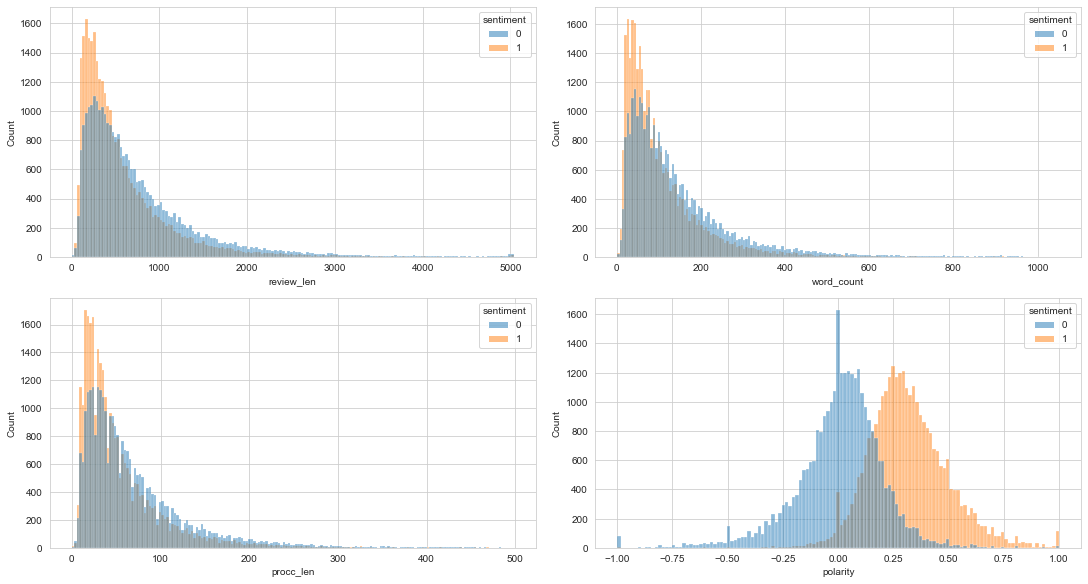

In [18]:
fig2, axes2 = plt.subplots(2,2, constrained_layout=True, figsize=(15,8))
sns.set_style('whitegrid')

sns.histplot(data = df_reviews, x= 'review_len', hue ='sentiment', ax=axes2[0,0])
sns.histplot(data = df_reviews, x= 'word_count', hue ='sentiment', ax=axes2[0,1])
sns.histplot(data = df_reviews, x= 'procc_len', hue ='sentiment', ax=axes2[1,0])
sns.histplot(data = df_reviews, x= 'polarity', hue ='sentiment', ax=axes2[1,1])

Dist of review length and #words are similar (as well as for the length of #procc words), though majority of reviews are short
and less then 80 words (procc_len) as shown with above. 
Another interesting note is - positive reviews tend to be shorter while negative -long. 

Polarity distribution of sentiment = 0 is close to normal - with mean close to 0 - meaning the reviews are objective mostly,
while sentiment = 1 has gaussian distribution with mean arround 0.25, having their reviews being slightly subjective

Text(0.5, 1.0, 'Sentiment vs #words')

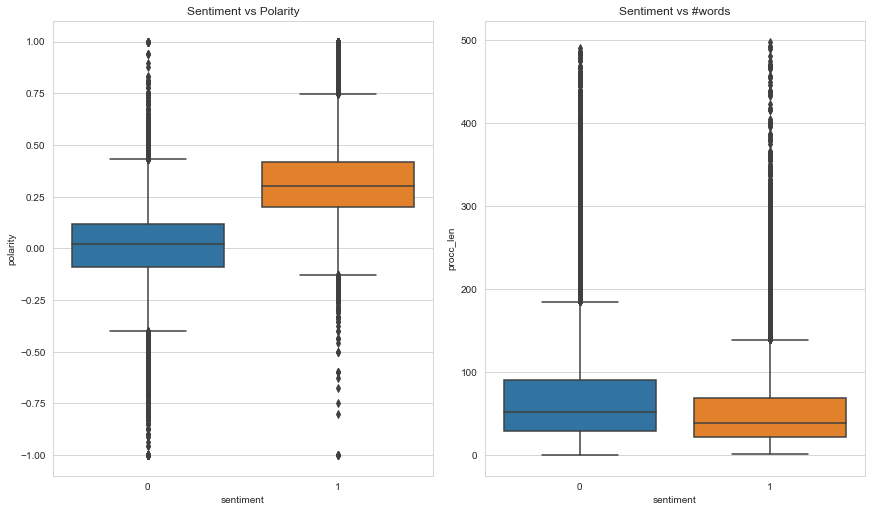

In [20]:
fig3, axes3 = plt.subplots(1,2, constrained_layout=True, figsize=(12,7))
sns.set_style('whitegrid')

sns.boxplot(data = df_reviews, x = 'sentiment', y='polarity', ax=axes3[0])
axes3[0].set_title("Sentiment vs Polarity")

sns.boxplot(data = df_reviews, x = 'sentiment', y='procc_len', ax=axes3[1])
axes3[1].set_title("Sentiment vs #words")

## Hyperparameter Optimization 

Find the  best hyperparameters for highest accuracy


In [21]:
vocab_size, data = vectorization_pad(df_reviews['procc_review'])
target = df_reviews['sentiment']

In [22]:
X_train, X_valid, X_test, y_train, y_valid, y_test = trainValidTestSplit(data, target)

Train set shape is: (35994, 500), with 17901 obsv labeld 0, 18093 obsv labeld 1
Validation set shape is: (11998, 500), with 6098 obsv labeld 0, 5900 obsv labeld 1
Test set shape is: (11999, 500), with 5997 obsv labeld 0, 6002 obsv labeld 1


In [27]:
embed_vector = [16,32,64,128]
epochs = [1,3,5,7]
batch_size = [100, 200, 400, 1600]
dropout_param1D = [0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.75]
dropout_param = [0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.75]
optimizer = ['RMSprop', 'adam', 'Adamax', 'sgd']


random_grid = dict(
    embed_vector=embed_vector,
    dropout_param1D=dropout_param1D,
    dropout_param = dropout_param,
    optimizer=optimizer,
    epochs=epochs,
    batch_size = batch_size
)

In [28]:
Tuner = HyperparameterTuner_Randomized(param_grid= random_grid, vocab_size = vocab_size, X_train=X_train,
                               Y_train= y_train, X_valid=X_valid, Y_valid= y_valid, n_iter= 5)

 Iteration #1,
            The chosen parameters are:
            Embed_vector:                    16,
            Dropout:                    0.25, 0.4,
            Optimizer:                       RMSprop,
            Batch & Epoch:              400, 7
            
sample #1 is done, 4 samples left
current accuracy is 0.9500194191932678
- - - - - - - - - - - - - - - - - - - - - -
 Iteration #2,
            The chosen parameters are:
            Embed_vector:                    128,
            Dropout:                    0.3, 0.3,
            Optimizer:                       adam,
            Batch & Epoch:              100, 1
            
sample #2 is done, 3 samples left
current accuracy is 0.9500194191932678
- - - - - - - - - - - - - - - - - - - - - -
 Iteration #3,
            The chosen parameters are:
            Embed_vector:                    128,
            Dropout:                    0.2, 0.75,
            Optimizer:                       RMSprop,
            Batch & Epoc

## Model Results


In [29]:
# Best parameters: 
embed_vector,dropout_param1D,dropout_1param, optimizer,batch_size,epochs = list(Tuner.parameters.values())

In [34]:
Tuner.ac3curacy

0.9538256525993347

In [35]:
Tuner.val_accuracy

0.9199866652488708

In [36]:
Tuner.loss

0.1271643489599228

In [37]:
model = MySequential(vocab_size, embed_vector, dropout_param1D, dropout_1param )

In [38]:
model.compile(loss='binary_crossentropy',optimizer=optimizer, metrics=['accuracy'])  
history = model.fit(X_train, y_train, validation_data = (X_valid, y_valid), epochs=epochs, batch_size=batch_size, verbose = 1)

Epoch 1/5
90/90 [==============================] - 668s 7s/step - loss: 0.3348 - accuracy: 0.8659 - val_loss: 0.2054 - val_accuracy: 0.9229
Epoch 2/5
90/90 [==============================] - 693s 8s/step - loss: 0.1811 - accuracy: 0.9335 - val_loss: 0.1912 - val_accuracy: 0.9272
Epoch 3/5
90/90 [==============================] - 684s 8s/step - loss: 0.1578 - accuracy: 0.9424 - val_loss: 0.1893 - val_accuracy: 0.9287
Epoch 4/5
90/90 [==============================] - 53267s 592s/step - loss: 0.1424 - accuracy: 0.9478 - val_loss: 0.1935 - val_accuracy: 0.9253
Epoch 5/5
90/90 [==============================] - 1066s 12s/step - loss: 0.1300 - accuracy: 0.9533 - val_loss: 0.2358 - val_accuracy: 0.9189


In [39]:
evaluation = model.evaluate(X_test, y_test, verbose=1)

375/375 [==============================] - 45s 120ms/step - loss: 0.2497 - accuracy: 0.9156


In [40]:
print('model keys: {}'.format(history.history.keys()))
print('model parameters: {}'.format(history.params))

model keys: dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
model parameters: {'verbose': 1, 'epochs': 5, 'steps': 90}


In [42]:
history.history['val_accuracy'][-1]

0.9189031720161438

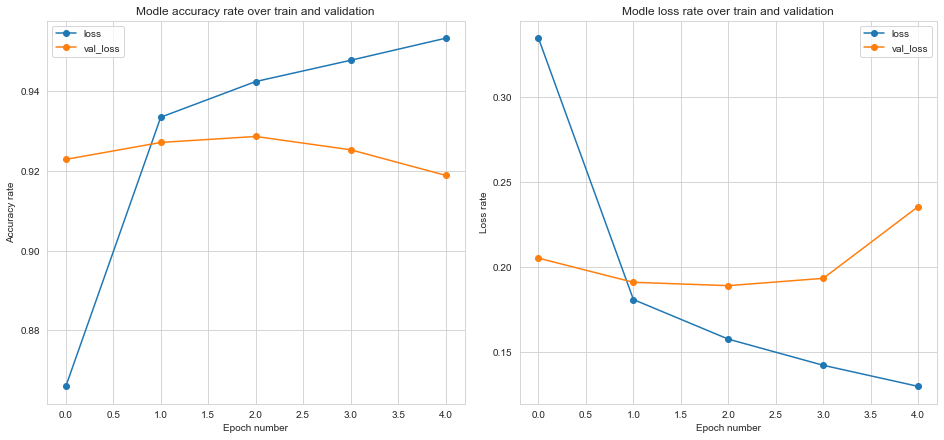

In [43]:
fig1, axes = plt.subplots(1,2,constrained_layout=True, figsize=(13,6))

axes[0].plot(history.history['accuracy'], label='loss', marker ='o')
axes[0].plot(history.history['val_accuracy'], label='val_loss', marker ='o')
axes[0].set_xlabel('Epoch number')
axes[0].set_ylabel('Accuracy rate')
axes[0].set_title('Modle accuracy rate over train and validation')
axes[0].legend()

axes[1].plot(history.history['loss'], label='loss', marker ='o')
axes[1].plot(history.history['val_loss'], label='val_loss', marker ='o')
axes[1].set_xlabel('Epoch number')
axes[1].set_ylabel('Loss rate')
axes[1].set_title('Modle loss rate over train and validation')
axes[1].legend()

In [44]:
evaluation

[0.24974702298641205, 0.9155762791633606]

Final Loss (Test Set) - 0.24974

Final Accuracy (Test Set)- 0.91557